# Hyper Parameter Optimization of Clustering Algorithms

## Q. How do you know how to set parameters such as linkage, metrics etc for an unsupervised clustering algorithms? 
## A. You can estimate clustering quality using intrinsic metrics such as sillouette score!

Dr. Hanan Shteingart, All rights reserved

## Get some DATA!
As usual, we will use the Iris dataset as an example...
![Iris](http://dataaspirant.com/wp-content/uploads/2017/01/irises.png)

In [6]:
from sklearn import datasets # import datasets package
import numpy as np # impoty numpy
import pandas as pd # import pandas package, this is for describing a dataset etc.
import matplotlib.pyplot as plt
# this is just for making plot inline in the notebook:
%matplotlib inline 
iris = datasets.load_iris() # get iris data into iris variable
# define a feature matrix
feature_matrix = iris['data'] # get the feature matrix
# define the labels. NOTE: we will regard these as unknowns!
labels = iris['target'] # get the label
n_labels = len(np.unique(labels)) # how many unique labels?
n_clusters = n_labels # set the clustering number to the correct one
# describe the data
print('There are %d samples and %d features'% (feature_matrix.shape[0], feature_matrix.shape[1]))
print('summary stats of the features')
print(pd.DataFrame(feature_matrix).describe())

There are 150 samples and 4 features
summary stats of the features
                0           1           2           3
count  150.000000  150.000000  150.000000  150.000000
mean     5.843333    3.054000    3.758667    1.198667
std      0.828066    0.433594    1.764420    0.763161
min      4.300000    2.000000    1.000000    0.100000
25%      5.100000    2.800000    1.600000    0.300000
50%      5.800000    3.000000    4.350000    1.300000
75%      6.400000    3.300000    5.100000    1.800000
max      7.900000    4.400000    6.900000    2.500000


# First thing first, Normalize!

In [7]:
from sklearn.preprocessing import scale
feature_matrix = scale(feature_matrix, axis=0)

# Build a simple clustering model

In [8]:
from sklearn.cluster.hierarchical import AgglomerativeClustering # import the Agglomerative Clustering algorithm

In [9]:
model = AgglomerativeClustering(linkage = "ward", n_clusters=n_clusters, affinity='euclidean') # initiate the model
y_hat=model.fit_predict(feature_matrix) # fit the model

# How well did we do?
## If we know the true undelying labels, it's easy!

In [13]:
from sklearn.metrics import homogeneity_score
print('score = %s' % homogeneity_score(labels_true=labels, labels_pred=y_hat))
print('perfect score = %s' % homogeneity_score(labels_true=labels, labels_pred=labels))

score = 0.657881807998
perfect score = 1.0


## What if we don't know the real labels?... more realistic scenario

We can use [Silhouette coefficients][1]. It's a number between -1 and 1. Near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

Assume the data have been clustered via any technique, such as k-means, into $k$ clusters. For each datum $i$, let $a(i)$ be the average dissimilarity of $i$ with all other data within the same cluster. We can interpre $a(i)$ as how well $i$ is assigned to its cluster (the smaller the value, the better the assignment). We then define the average dissimilarity of point $i$ to a cluster $c$ as the average of the distance from $i$ to all points in $c$.


Let $b(i)$ be the lowest average dissimilarity of $i$ to any other cluster, of which $i$ is NOT a member. The cluster with this lowest average dissimilarity is said to be the "neighbouring cluster" of $i$ because it is the next best fit cluster for point $i$. We now define a silhouette:

$s(i) = \frac{b(i) - a(i)}{\max\{a(i),b(i)\}}$


[1]: https://en.wikipedia.org/wiki/Silhouette_(clustering)

In [14]:
from sklearn.metrics import silhouette_score
print('score = %s' % silhouette_score(feature_matrix, y_hat, metric='euclidean'))
print('perfect score = %s' % silhouette_score(feature_matrix, labels, metric='euclidean'))

score = 0.445539563992
perfect score = 0.379753292616


In [15]:
# Helper function to compute both scores and print it

In [16]:
# calc performance
from sklearn.metrics.cluster import silhouette_score, homogeneity_score, calinski_harabaz_score
def calc_metric(x, labels_true, labels_pred):
    return {'homogeneity': homogeneity_score(labels_true, labels_pred), 
            'silhoette': silhouette_score(x, labels_pred, metric='euclidean')}
def print_dict(d):
    for k, v in d.items():
        print('%s = %s' % (k,v))

In [17]:
print('true labels:')
print('============')
print_dict(calc_metric(feature_matrix, labels, labels))
print('predicted labels:')
print('=================')
print_dict(calc_metric(feature_matrix, labels, y_hat))

true labels:
homogeneity = 1.0
silhoette = 0.379753292616
predicted labels:
homogeneity = 0.657881807998
silhoette = 0.445539563992


# How do intrinc metrics change when data is shuffles

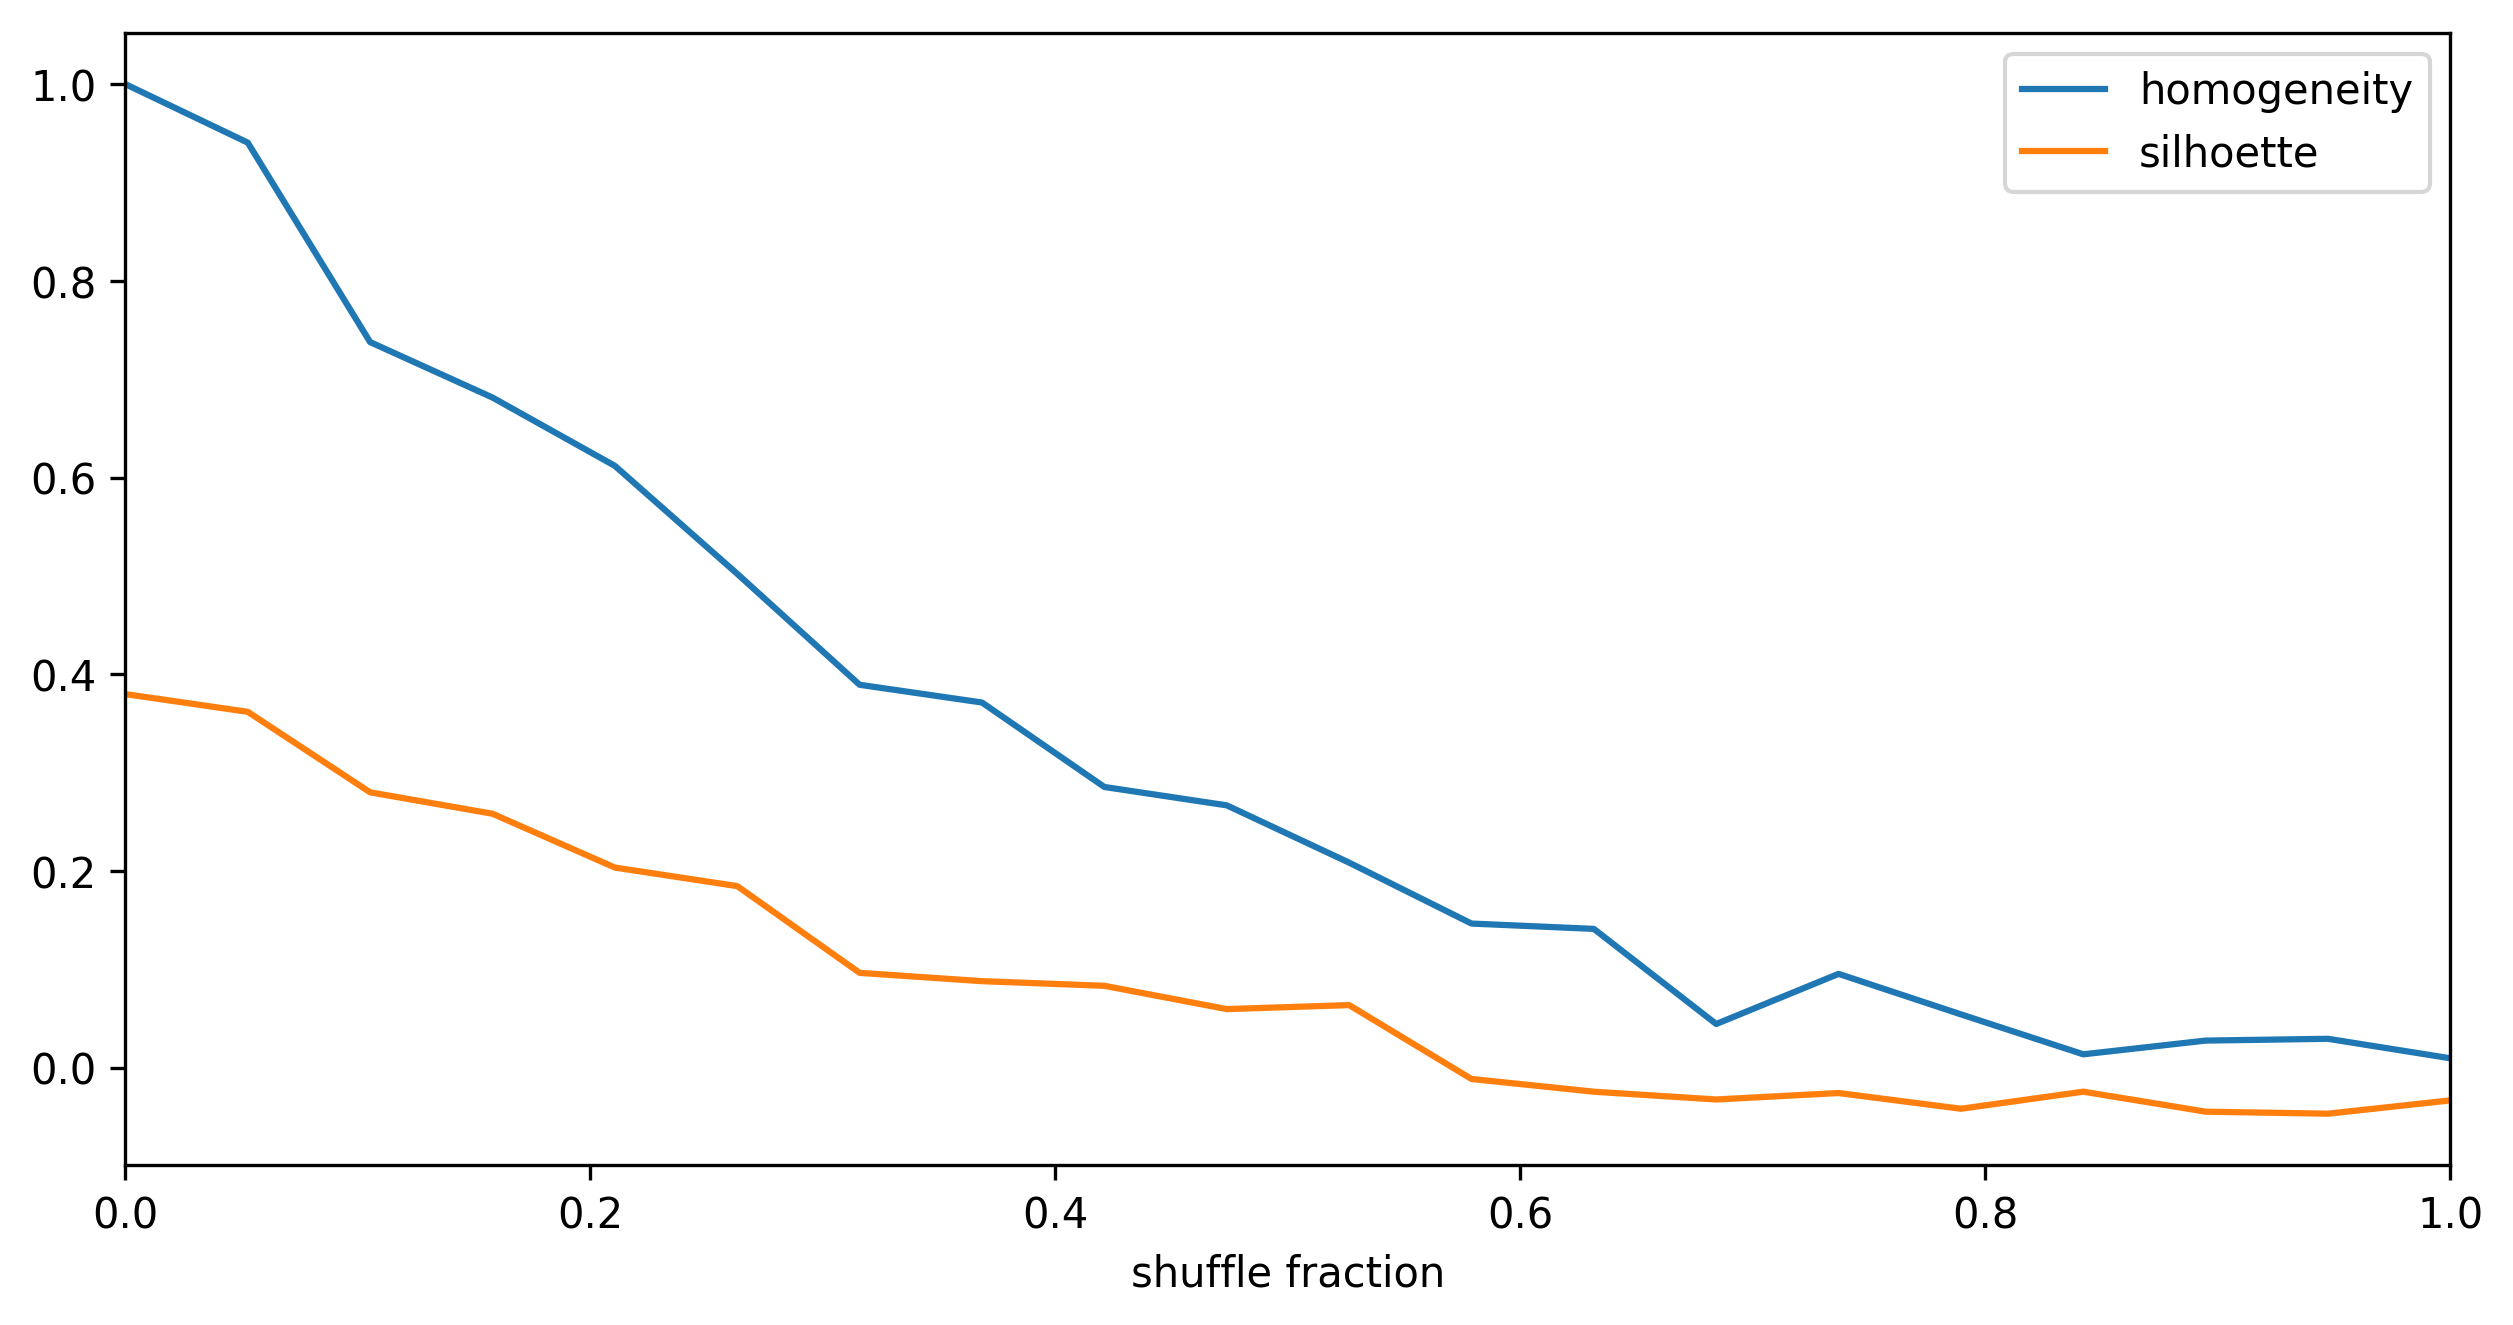

In [18]:
from sklearn.utils import shuffle

shuffle_size_list = np.linspace(0,1,20) # define a shuffle size range
metric = [] # an empty list to contain the results
n = len(labels) # data set size
index = np.arange(n) # index 0:n-1 in an array to be used for shuffeling
for shuffle_size in shuffle_size_list: # for every shuffle size
    size = int(np.round(shuffle_size * n))
    shuffle_indices = np.random.choice(index, size=size ,replace=False)
    y_hat = labels.copy() # copy by value to protect original array
    y_hat[shuffle_indices] = shuffle(y_hat[shuffle_indices]) # create a shuffled version
    metric.append(calc_metric(feature_matrix, labels, y_hat)) # keep the result

# convert to a pandas's DataFrame
metric_df = pd.DataFrame(metric)
# plot
metric_df.index = shuffle_size_list
metric_df.index.name = 'shuffle fraction'
plt.figure(figsize=(10,5), dpi=300)
metric_df.plot(legend=True, ax = plt.gca());

# Interim Concolusion 
Intrinsic measurement such as sillouette can be a proxy for clustering performance even if we do NOT know the true underlying true labels

# Hyper Parameter Clustering Optimization Using Intrinsic Metric
So, if we can measure performance, we can optimize meta-parameters of the clustering. 
Let's take as an example the problem of decising on the linkage method.

Reminder:
![type of linkages](https://i.ytimg.com/vi/vg1w5ZUF5lA/maxresdefault.jpg)
[source of image](https://i.ytimg.com/vi/vg1w5ZUF5lA/maxresdefault.jpg)

# Loop around parameters and decide which is best

ground truth:
homogeneity = 1.0
silhoette = 0.379753292616


/home/hanan/anaconda3/lib/python3.6/site-packages/pandas/tools/plotting.py:2470: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe193688978>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fe18e66ba58>], dtype=object)

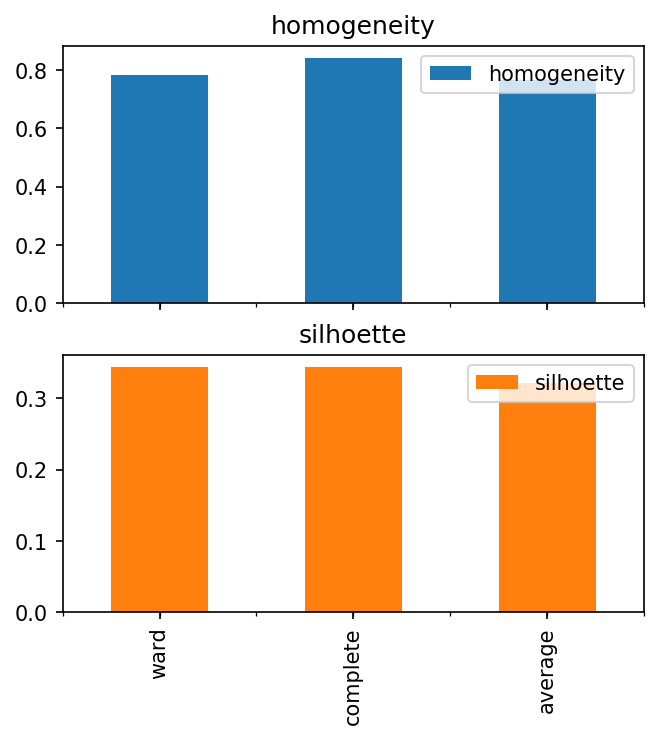

In [33]:
LINKAGES = ["ward", "complete", "average"]
print('ground truth:')
print_dict(calc_metric(feature_matrix, labels, labels))
metric = []
for linkage in LINKAGES:
    model = AgglomerativeClustering(linkage =linkage, n_clusters=n_clusters, affinity='euclidean')
    y_hat = model.fit_predict(feature_matrix)
    metric.append(calc_metric(feature_matrix, labels, y_hat))
df = pd.DataFrame(metric, index=LINKAGES)
plt.figure(figsize=(5,5), dpi=150)
df.plot(kind='bar', subplots=True,ax = plt.gca(), sharex=True)

# life is tough. Sometimes it doen't work

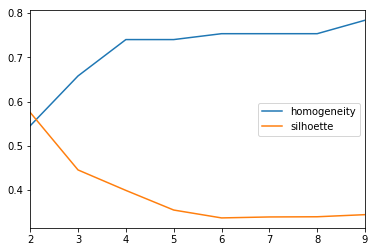

In [28]:
CLUSTER_SIZE = np.arange(2,10)
metric = []
for n_clusters in CLUSTER_SIZE:
    model = AgglomerativeClustering(linkage ='ward', n_clusters=n_clusters)
    y_hat = model.fit_predict(feature_matrix)
    current_metric = calc_metric(feature_matrix, labels, y_hat)
    metric.append(current_metric)
df = pd.DataFrame(metric, index=CLUSTER_SIZE)
df.plot()

# Life is Tough :-)
But at least in [toy examples](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py) it works welll...

# References

1. [Sklearn Clustering Metrics](http://scikit-learn.org/stable/modules/classes.html#clustering-metrics)
2. [Choosing the right linkage method for hierarchical clustering](https://stats.stackexchange.com/questions/195446/choosing-the-right-linkage-method-for-hierarchical-clustering)
2. [How to select a clustering method? How to validate a cluster solution (to warrant the method choice)?](https://stats.stackexchange.com/questions/195456/how-to-select-a-clustering-method-how-to-validate-a-cluster-solution-to-warran/195481#195481)
3. [Calinski-Harabaz Index](http://scikit-learn.org/stable/modules/clustering.html#calinski-harabaz-index)
4. [Sillohette][1]

[1]: https://en.wikipedia.org/wiki/Silhouette_(clustering)